In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

PyTorch Version: 1.11.0+cu113
Torchvision Version: 0.12.0+cu113
GPU is available? True


In [2]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imported datasets
For the testing and comparison of our algorithms we will use the following datasets:

1. MNIST

In [3]:
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Train - test split

Code taken from https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb

In [4]:
#train-set initialization
x_d0 = mnist_trainset[0][0].size()[0]
x_d1 = mnist_trainset[0][0].size()[1]
x_d2 = mnist_trainset[0][0].size()[2]
N = x_d3 = len(mnist_trainset)
K = 10
x_train = torch.empty((N,x_d0*x_d1*x_d2), device=device)
y_train = torch.empty(N, dtype=torch.long)
for i in range(N): 
    x_train[i,:] = torch.reshape(mnist_trainset[i][0], (1, x_d0*x_d1*x_d2))
    y_train[i] = mnist_trainset[i][1]
x_train = torch.t(x_train)
#y_one_hot = torch.zeros(N, K).scatter_(1, torch.reshape(y_train, (N, 1)), 1)
#y_one_hot = torch.t(y_one_hot).to(device=device)
y_train = y_train.to(device=device)

#test-set initialization
N_test = x_d3_test = len(mnist_testset)
x_test = torch.empty((N_test,x_d0*x_d1*x_d2), device=device)
y_test = torch.empty(N_test, dtype=torch.long)
for i in range(N_test): 
    x_test[i,:] = torch.reshape(mnist_testset[i][0], (1, x_d0*x_d1*x_d2))
    y_test[i] = mnist_testset[i][1]
x_test = torch.t(x_test)
#y_test_one_hot = torch.zeros(N_test, K).scatter_(1, torch.reshape(y_test, (N_test, 1)), 1)
#y_test_one_hot = torch.t(y_test_one_hot).to(device=device)
y_test = y_test.to(device=device)

# Architecture initialization

For the MultiLayerPerceptron we have the parameters **input_size** , **hidden_size**,**output_size** corresponding to the size of the input layer, the hidden layer and the output layer, respectively.

The MLP only has 3 layers like https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb as a starting point.

Also we use ReLU currently for the same reason.

In [5]:
input_size = 28*28
hidden_size = 1500
output_size = 10

In [6]:
torch.manual_seed(32)
d0 = input_size
d1 = d2 = 1500
d3 = output_size 

# The layers are: input + 2 hidden + output

# we represent the weigths of each layer as matrices with d_{i-1} columns and d_{i} rows

# Weight initialization (we replicate pytorch initialization)
std_1 = math.sqrt(1/d0)
W1 = torch.FloatTensor(d1, d0).uniform_(-std_1, std_1)
b1 = torch.FloatTensor(d1, 1).uniform_(-std_1, std_1)

# we move them to GPU
b1 = b1.to('cuda:0')
W1 = W1.to('cuda:0')


std_2 = math.sqrt(1/d1)
W2 = torch.FloatTensor(d2, d1).uniform_(-std_2, std_2)
b2 = torch.FloatTensor(d2, 1).uniform_(-std_2, std_2)

# we move them to GPU
b2 = b2.to('cuda:0')
W2 = W2.to('cuda:0')

std_3 = math.sqrt(1/d2)
W3 = torch.FloatTensor(d3, d2).uniform_(-std_3, std_3)
b3 = torch.FloatTensor(d3, 1).uniform_(-std_3, std_3)

# we move them to GPU
b3 = b3.to('cuda:0')
W3 = W3.to('cuda:0')


U1 = torch.addmm(b1.repeat(1, N), W1, x_train) # equivalent to W1@x_train+b1.repeat(1,N)
V1 = nn.ReLU()(U1)
U2 = torch.addmm(b2.repeat(1, N), W2, V1)
V2 = nn.ReLU()(U2)
U3 = torch.addmm(b3.repeat(1, N), W3, V2)
V3 = U3

# constant initializations
gamma = 1
gamma1 = gamma2 = gamma3 = gamma4 = gamma

rho = gamma
rho1 = rho2 = rho3 = rho4 = rho


alpha = 5
alpha1 = alpha2 = alpha3 = alpha4 = alpha5 = alpha6 = alpha7 \
= alpha8 = alpha9 = alpha10 = alpha

# initialization of the vectors of losses and accuracies
niter = 500
loss1 = np.empty(niter)
loss2 = np.empty(niter)
accuracy_train = np.empty(niter)
accuracy_test = np.empty(niter)
time1 = np.empty(niter)

In [7]:
def updateV_js(U1,U2,W,b,rho,gamma): 
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho*(torch.mm(torch.t(W),W))+gamma*I), rho*torch.mm(torch.t(W),U2-b.repeat(1,col_U2))+gamma*U1)
    return Vstar

In [8]:
def updateWb_js(U, V, W, b, alpha, rho): 
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse(alpha*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = (alpha*b+rho*torch.sum(U-torch.mm(W,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

In [9]:
def relu_prox(a, b, gamma, d, N):
    val = torch.empty(d,N, device=device)
    x = (a+gamma*b)/(1+gamma)
    y = torch.min(b,torch.zeros(d,N, device=device))
    # torch.zeros(d,N, device=device)
    val = torch.where(a+gamma*b < 0, y, torch.zeros(d,N, device=device))
    val = torch.where(((a+gamma*b >= 0) & (b >=0)) | ((a*(gamma-np.sqrt(gamma*(gamma+1))) <= gamma*b) & (b < 0)), x, val)
    val = torch.where((-a <= gamma*b) & (gamma*b <= a*(gamma-np.sqrt(gamma*(gamma+1)))), b, val)
    return val

In [10]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def random_select(min,max,nodes,dims):
  """
  This function generates a set of indexes to chose which nodes of the layer we will update
  :param min: the minimum index from which the nodes will be chosen
  :param max: the maximum index from which the nodes will be chosen
  :param nodes: the number of nodes that should be chosen
  :param dims: the second dimension of the layer 
  :return layers,res: two lists that index together randomly selected elements in the layers
  """
  res = []
  layers = []
  for i in range(dims):
    res.append(random.sample(range(min,max),nodes))
    layers.append([i]*nodes)
  return flatten(layers),flatten(res)

In [11]:
nodes = 1000
layers = 10

In [12]:
# we perform one-hot encoding on the y-> y_one_hot will be a tensor of dimension 10*training_samples, for each sample there
# will be a one in the row corresponding to the class.

y_one_hot = torch.zeros(N, K).to(device = device).scatter_(1, torch.reshape(y_train,(N,1)), 1)
y_one_hot = torch.t(y_one_hot).to(device=device)

y_test_one_hot = torch.zeros(N_test, K).to(device = device).scatter_(1, torch.reshape(y_test,(N_test,1)), 1)
y_test_one_hot = torch.t(y_test_one_hot).to(device=device)

# Iterations
print('Train on', N, 'samples, validate on', N_test, 'samples')
for k in range(niter):

  start = time.time()

  #select_the nodes for the third layer
  layers_3,nodes_3 = random_select(0,V3.shape[1],nodes,layers)
  # update V3
  V3[layers_3,nodes_3] = (y_one_hot[layers_3,nodes_3] + gamma3*U3[layers_3,nodes_3] + alpha1*V3[layers_3,nodes_3])/(1+ gamma3 + alpha1)
      
  # update U3 
  U3[layers_3,nodes_3] = (gamma3*V3[layers_3,nodes_3] + rho3*(torch.mm(W3,V2)[layers_3,nodes_3] + b3.repeat(1,N)[layers_3,nodes_3]))/(gamma3 + rho3)

  # update W3 and b3
  W3, b3 = updateWb_js(U3,V2,W3,b3,alpha1,rho3)
      
  layers_2,nodes_2 = random_select(0,V2.shape[1],nodes,layers)
  # update V2
  V2[layers_2,nodes_2] = updateV_js(U2,U3,W3,b3,rho3,gamma2)[layers_2,nodes_2]
      
  # update U2
  U2[layers_2,nodes_2] = relu_prox(V2,(rho2*torch.addmm(b2.repeat(1,N), W2, V1) + alpha2*U2)/(rho2 + alpha2),(rho2 + alpha2)/gamma2,d2,N)[layers_2,nodes_2]
      
  # update W2 and b2
  W2, b2 = updateWb_js(U2,V1,W2,b2,alpha3,rho2)
  
  layers_1,nodes_1 = random_select(0,V1.shape[1],nodes,layers)
  # update V1
  V1[layers_1,nodes_1] = updateV_js(U1,U2,W2,b2,rho2,gamma1)[layers_1,nodes_1]
      
  # update U1
  U1[layers_1,nodes_1] = relu_prox(V1,(rho1*torch.addmm(b1.repeat(1,N), W1, x_train) + alpha7*U1)/(rho1 + alpha7),(rho1 + alpha7)/gamma1,d1,N)[layers_1,nodes_1]
  
  # update W1 and b1
  W1, b1 = updateWb_js(U1,x_train,W1,b1,alpha8,rho1)

  a1_train = nn.ReLU()(torch.addmm(b1.repeat(1, N), W1, x_train))
  a2_train = nn.ReLU()(torch.addmm(b2.repeat(1, N), W2, a1_train))
  pred = torch.argmax(torch.addmm(b3.repeat(1, N), W3, a2_train), dim=0)

  a1_test = nn.ReLU()(torch.addmm(b1.repeat(1, N_test), W1, x_test))
  a2_test = nn.ReLU()(torch.addmm(b2.repeat(1, N_test), W2, a1_test))
  pred_test = torch.argmax(torch.addmm(b3.repeat(1, N_test), W3, a2_test), dim=0)
      
  loss1[k] = gamma3/2*torch.pow(torch.dist(V3,y_one_hot,2),2).cpu().numpy()
  loss2[k] = loss1[k] + rho1/2*torch.pow(torch.dist(torch.addmm(b1.repeat(1,N), W1, x_train),U1,2),2).cpu().numpy() \
  +rho2/2*torch.pow(torch.dist(torch.addmm(b2.repeat(1,N), W2, V1),U2,2),2).cpu().numpy() \
  +rho3/2*torch.pow(torch.dist(torch.addmm(b3.repeat(1,N), W3, V2),U3,2),2).cpu().numpy()
      
  # compute training accuracy
  correct_train = pred == y_train
  accuracy_train[k] = np.mean(correct_train.cpu().numpy())
      
  # compute validation accuracy
  correct_test = pred_test == y_test
  accuracy_test[k] = np.mean(correct_test.cpu().numpy())
      
  # compute training time
  stop = time.time()
  duration = stop - start
  time1[k] = duration
      
  # print results
  print('Epoch', k + 1, '/', niter, '\n', 
        '-', 'time:', time1[k], '-', 'sq_loss:', loss1[k], '-', 'tot_loss:', loss2[k], 
        '-', 'acc:', accuracy_train[k], '-', 'val_acc:', accuracy_test[k])

Train on 60000 samples, validate on 10000 samples
Epoch 1 / 500 
 - time: 0.7711107730865479 - sq_loss: 31239.412109375 - tot_loss: 31242.052206335735 - acc: 0.07686666666666667 - val_acc: 0.0755
Epoch 2 / 500 
 - time: 0.7383406162261963 - sq_loss: 31168.376953125 - tot_loss: 31173.57671582335 - acc: 0.0824 - val_acc: 0.0802
Epoch 3 / 500 
 - time: 0.7412509918212891 - sq_loss: 31094.423828125 - tot_loss: 31102.299335848045 - acc: 0.08826666666666666 - val_acc: 0.0868
Epoch 4 / 500 
 - time: 0.7308990955352783 - sq_loss: 31023.02734375 - tot_loss: 31033.505705717078 - acc: 0.0946 - val_acc: 0.0935
Epoch 5 / 500 
 - time: 0.7308847904205322 - sq_loss: 30952.26953125 - tot_loss: 30965.214714645 - acc: 0.1 - val_acc: 0.0987
Epoch 6 / 500 
 - time: 0.7446532249450684 - sq_loss: 30881.130859375 - tot_loss: 30896.512658254127 - acc: 0.10641666666666667 - val_acc: 0.1059
Epoch 7 / 500 
 - time: 0.7403552532196045 - sq_loss: 30811.40234375 - tot_loss: 30829.339386011998 - acc: 0.1125833333333

# Training

Note: Fix it so that it moves everything to device in the following function and that it does the label sample split here

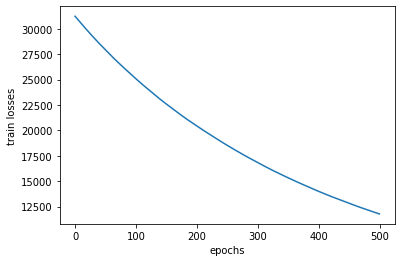

In [13]:
## We plot the train losses

plt.xlabel('epochs')
plt.ylabel('train losses')
plt.plot(np.arange(0,loss1.shape[0]), loss1)
plt.show()

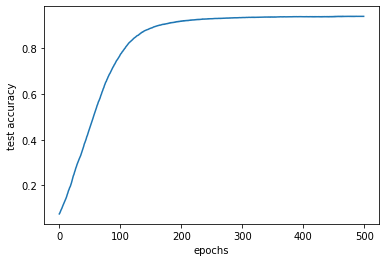

In [14]:
## We plot the test accuracy

plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.plot(np.arange(0, accuracy_test.shape[0]), accuracy_test)
plt.show()